In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
## Imports
import warnings
warnings.filterwarnings('ignore')

import sys

# if "google.colab" in sys.modules:
    # !sudo add-apt-repository -y ppa:deadsnakes/ppa
    # !sudo apt-get -y update
    # !sudo apt-get -y install python3.9
    # !sudo apt-get -y install python3.9-dev
    # !sudo apt-get -y install python3-pip
    # !sudo apt-get -y install python3.9-distutils
    # !python3.9 -m pip install --upgrade setuptools
    # !python3.9 -m pip install --upgrade pip
    # !python3.9 -m pip install --upgrade distlib

    # !sudo update-alternatives --set python /usr/bin/python3.9
    # !sudo ln -sf /usr/bin/python /usr/local/bin/python

    # #install python 3.9
    # !sudo apt-get update -y
    # !sudo apt-get install python3.9

    # #change alternatives
    # !sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.7 1
    # !sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.9 2

    # !python3.9 setup.py
    
    # !pip uninstall lightgbm -y
    # !pip install lightgbm==3.3.1
    # !pip uninstall catboost -y
    # !pip install catboost==1.0.6
    # !pip install Levenshtein
    # !pip uninstall pandas -y
    # !pip install pandas==1.4.1

import os
import gc
import time
import random
import pickle
# import Levenshtein
import difflib
import joblib
import multiprocessing
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
# import lightgbm as lgb
# from catboost import CatBoost
# from catboost import Pool
from tqdm.auto import tqdm
from requests import get
from collections import Counter, defaultdict
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

In [3]:
!pip install feather-format

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import feather

In [5]:
## Parameters
class CFG:
    AUTHOR = "kuruton"
    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]
    ROOT_DIR = '/content/drive/MyDrive/Kaggle/Foursquare'
    DATASET_DIR = os.path.join(ROOT_DIR, 'Dataset')
    INPUT_DIR = os.path.join(ROOT_DIR, 'Input')
    OUTPUT_DIR = os.path.join(ROOT_DIR, 'Output')
    PROCESSED_DIR = os.path.join(ROOT_DIR, 'processed_data')
    is_debug = True
    SEED = 2022
    num_neighbors = 20
    num_split = 5
    feat_columns = ['name', 'address', 'city', 
                'state', 'zip', 'url', 
              'phone', 'categories', 'country']
    vec_columns = ['name', 'categories', 'address', 
                  'state', 'url', 'country']

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG.SEED)

In [6]:
if not os.path.exists(os.path.join(CFG.OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(CFG.OUTPUT_DIR, CFG.expID))

In [7]:
## Data load
if "google.colab" in sys.modules:
    data_root = CFG.INPUT_DIR
else:
    data_root = '../input/foursquare-location-matching'
test_df = pd.read_csv(os.path.join(data_root, 'train.csv'))

if CFG.is_debug:
    test_df = test_df[:100000]
    test_df = test_df.reset_index(drop = True)

In [8]:
pred_df = pd.read_csv(os.path.join(CFG.PROCESSED_DIR, "pred31_score_and_rank.csv"))
pred_df.head()

,query_ix,candidate_ix,pred,rank,fold
0,6,903995,0.015949,1.0,0
1,6,305579,0.001998,2.0,0
2,6,238967,0.264468,3.0,0
3,6,786499,0.023800,4.0,0
4,6,549946,0.026928,5.0,0


In [9]:
if CFG.is_debug:
    print(pred_df.shape)
    pred_df = pred_df[(pred_df['query_ix'] < 100000) & (pred_df['candidate_ix'] < 100000)]
    print(pred_df.shape)

(36441984, 5)
(410036, 5)


In [10]:
query_col = "query_ix"
candidate_col = "candidate_ix"
score_col = "pred"

In [11]:
from itertools import groupby

class UnionFind():
    
    def __init__(self, N):
        self.parent = [-1] * N
        self.size = [1] * N
        
    def find(self, x):
        p = self.parent[x]
        if p == -1:
            return x
        p = self.find(p)
        self.parent[x] = p
        return p
    
    def unite(self, x, y):
        px = self.find(x)
        py = self.find(y)
        if px == py:
            return
        if self.size[px] < self.size[py]:
            px, py = py, px
        self.size[px] += self.size[py]
        self.parent[py] = px

In [12]:
import networkx as nx
from heapq import heappop, heappush
from tqdm.notebook import tqdm
warnings.simplefilter('ignore')

In [13]:
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame):
    scores = []
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores

In [14]:
id2poi = get_id2poi(test_df)
poi2ids = get_poi2ids(test_df)

In [15]:
# !pip install optuna

In [16]:
# import optuna

In [17]:
# def objective(trial):
#     pred_df_ = pred_df[pred_df['pred'] > 0.93]
#     max_dist = 2
#     max_N = trial.suggest_int('max_N', 2, 1000)
#     shortest_paths_threshold = 1000#trial.suggest_int('shortest_paths_threshold', , 1000)
#     eval_points = list(range(len(test_df)))

#     submission_df = test_df[["id"]]
#     submission_df["matches"] = test_df["id"]

#     uft = UnionFind(len(test_df))

#     for ix, nix in pred_df_[["query_ix", "candidate_ix"]].values:
#         uft.unite(ix, nix)
#     group_members = defaultdict(list)
#     group_size = defaultdict(int)
#     group_map = {}
#     for i in range(len(test_df)):
#         group_members[uft.find(i)].append(i)
#         group_size[uft.find(i)] = uft.size[uft.find(i)]
#         group_map[i] = uft.find(i)

#     large_groups = set([k for k, v in group_size.items() if v > min(max_N, max_dist+1)])

#     pred_df_["group"] = pred_df_["query_ix"].map(group_map)
#     pred_df_["size"] = pred_df_["group"].map(group_size)
#     pred_df_["left"] = np.minimum(pred_df_["query_ix"], pred_df_["candidate_ix"])
#     pred_df_["right"] = np.maximum(pred_df_["query_ix"], pred_df_["candidate_ix"])
#     pred_df_ = pred_df_.sort_values(by="pred", ascending=False).drop_duplicates(["left", "right"])

#     graphs = {k: nx.Graph() for k in large_groups}
#     for large_group in large_groups:
#         for member in group_members[large_group]:
#             graphs[large_group].add_node(member)

#     neighbors = defaultdict(list)
#     for l, r, s in pred_df_[pred_df_["group"].isin(large_groups)][["left", "right", "pred"]].values:
#         l, r = int(l), int(r)
#         g = uft.find(l)
#         neighbors[l].append((r, s))
#         neighbors[r].append((l, s))
#         graphs[g].add_edge(l, r)

#     shortest_paths = {g: {k: d for k, d in nx.all_pairs_shortest_path_length(graphs[g])} for g in large_groups if len(group_members[g]) < shortest_paths_threshold}

#     matches = []
#     for i in eval_points:
#         g = uft.find(i)
#         preds = []
#         if g in large_groups:
#             if g in shortest_paths.keys():
#                 for n, d in shortest_paths[g][i].items():
#                     if d <= max_dist:
#                         preds.append(n)
#             if (len(preds) > max_N) or (not g in shortest_paths.keys()):
#                 searched = set()
#                 heapq = [(-1., 0, i)]
#                 while len(heapq) and (len(searched) < max_N):
#                     _, step, x = heappop(heapq)
#                     if x in searched:
#                         continue
#                     searched.add(x)
#                     if step >= max_dist:
#                         continue
#                     for n, s in neighbors[x]:
#                         if n in searched:
#                             continue
#                         heappush(heapq, (-s, step+1, n))
#                 preds = list(searched)
#         else:
#             preds = group_members[g]
#         matches.append(" ".join([test_df.at[p, "id"] for p in preds]))
#     submission_df["matches"] = matches
#     cv = get_score(submission_df)
#     print("CV:" + str(cv))
#     return cv

In [18]:
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

In [19]:
# study.best_params

In [20]:
1

1

In [21]:
pred_df_ = pred_df[pred_df['pred'] > 0.93]
max_dist = 2
max_N = 256
shortest_paths_threshold = 1000
eval_points = list(range(len(test_df)))

submission_df = test_df[["id"]]
submission_df["matches"] = test_df["id"]

uft = UnionFind(len(test_df))

for ix, nix in pred_df_[["query_ix", "candidate_ix"]].values:
    uft.unite(ix, nix)
group_members = defaultdict(list)
group_size = defaultdict(int)
group_map = {}
for i in range(len(test_df)):
    group_members[uft.find(i)].append(i)
    group_size[uft.find(i)] = uft.size[uft.find(i)]
    group_map[i] = uft.find(i)

large_groups = set([k for k, v in group_size.items() if v > min(max_N, max_dist+1)])

pred_df_["group"] = pred_df_["query_ix"].map(group_map)
pred_df_["size"] = pred_df_["group"].map(group_size)
pred_df_["left"] = np.minimum(pred_df_["query_ix"], pred_df_["candidate_ix"])
pred_df_["right"] = np.maximum(pred_df_["query_ix"], pred_df_["candidate_ix"])
pred_df_ = pred_df_.sort_values(by="pred", ascending=False).drop_duplicates(["left", "right"])

graphs = {k: nx.Graph() for k in large_groups}
for large_group in large_groups:
    for member in group_members[large_group]:
        graphs[large_group].add_node(member)

neighbors = defaultdict(list)
for l, r, s in pred_df_[pred_df_["group"].isin(large_groups)][["left", "right", "pred"]].values:
    l, r = int(l), int(r)
    g = uft.find(l)
    neighbors[l].append((r, s))
    neighbors[r].append((l, s))
    graphs[g].add_edge(l, r)

shortest_paths = {g: {k: d for k, d in nx.all_pairs_shortest_path_length(graphs[g])} for g in large_groups if len(group_members[g]) < shortest_paths_threshold}

matches = []
for i in eval_points:
    g = uft.find(i)
    preds = []
    if g in large_groups:
        if g in shortest_paths.keys():
            for n, d in shortest_paths[g][i].items():
                if d <= max_dist:
                    preds.append(n)
        if (len(preds) > max_N) or (not g in shortest_paths.keys()):
            searched = set()
            heapq = [(-1., 0, i)]
            while len(heapq) and (len(searched) < max_N):
                _, step, x = heappop(heapq)
                if x in searched:
                    continue
                searched.add(x)
                if step >= max_dist:
                    continue
                for n, s in neighbors[x]:
                    if n in searched:
                        continue
                    heappush(heapq, (-s, step+1, n))
            preds = list(searched)
    else:
        preds = group_members[g]
    matches.append(" ".join([test_df.at[p, "id"] for p in preds]))
submission_df["matches"] = matches
scores = get_score(submission_df)
print("CV:" + str(scores.mean()))

CV:0.9749669064985123


In [28]:
ix2id = dict(zip(test_df.index, test_df['id']))
id2ix = dict(zip(test_df['id'], test_df.index))

In [33]:
submission_df = pd.DataFrame()
submission_df['id'] = test_df['id']
submission_df['matches'] = test_df['id']

In [34]:
for ix, nixs in pred_df[pred_df['pred'] > 0.93].groupby('query_ix')['candidate_ix']:
    matches = [ix2id[nix] for nix in nixs]
    matches = ' '.join(matches)
    submission_df.loc[ix, 'matches'] += ' ' + matches

In [35]:
def postprocess(df):
    id2match = dict(zip(df["id"].values, df["matches"].str.split()))

    for match in tqdm(df["matches"]):
        match = match.split()
        if len(match) == 1:
            continue

        base = match[0]
        for m in match[1:]:
            if not base in id2match[m]:
                id2match[m].append(base)
    df["matches"] = df["id"].map(id2match).map(" ".join)
    return df 

submission_df = postprocess(submission_df)
scores = get_score(submission_df)
print("CV:" + str(scores.mean()))

  0%|          | 0/100000 [00:00<?, ?it/s]

CV:0.9743811679568797


(array([1.6100e+02, 1.8000e+02, 1.8400e+02, 4.7700e+02, 3.2620e+03,
        4.7000e+01, 2.4300e+02, 8.2000e+01, 2.0000e+01, 9.5344e+04]),
 array([0.03703704, 0.13333333, 0.22962963, 0.32592593, 0.42222222,
        0.51851852, 0.61481481, 0.71111111, 0.80740741, 0.9037037 ,
        1.        ]),
 <a list of 10 Patch objects>)

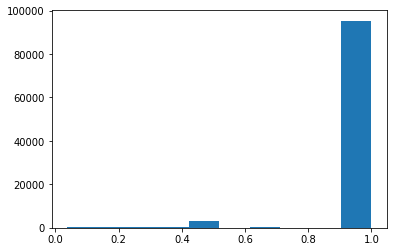

In [23]:
plt.hist(scores)